Poisson Equation
===

Import Netgen/NGSolve Python modules:

In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
from math import log

In [2]:
N = 16
T = 0.2
tau = T/N 
gamma0 = 1
gamma1 = 1
gamma_dual = 1e-5
gamma_M = 1
maxh = 0.0375
solver = "pardiso"
#solver = "umfpack"

The unit_square is a predefined domain, use Netgen to generate a mesh:

In [3]:
def GetMeshDataAllAround(maxh):
    geo = SplineGeometry()
    # data domain
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (1,0)
    p4 = geo.AppendPoint (0.75,0.75)
    p5 = geo.AppendPoint (0.75,0.25)
    p6 = geo.AppendPoint (0.25,0.25)
    p7 = geo.AppendPoint (0.25,0.75)
    p11 = geo.AppendPoint(1.0,1.0)
    p12 = geo.AppendPoint(0.0,1.0)
    # omega
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p11], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p11, p12], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p12, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B
    geo.Append (["line", p6, p5], leftdomain=2, rightdomain=1)
    geo.Append (["line", p5, p4], leftdomain=2, rightdomain=1)
    geo.Append (["line", p4, p7], leftdomain=2, rightdomain=1)
    geo.Append (["line", p7, p6], leftdomain=2, rightdomain=1)
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [4]:
def GetMeshDataLeft(maxh):
    geo = SplineGeometry()
    p1 = geo.AppendPoint (0,0)
    p2 = geo.AppendPoint (0.25,0)
    p3 = geo.AppendPoint (0.25,1)
    p4 = geo.AppendPoint (0,1)
    p5 = geo.AppendPoint (1,0)
    p6 = geo.AppendPoint (1,1)
    # omega 
    geo.Append (["line", p1, p2], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p2, p3], leftdomain=1, rightdomain=2)
    geo.Append (["line", p3, p4], leftdomain=1, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p4, p1], leftdomain=1, rightdomain=0,bc="bc_Omega")
    # only_B 
    geo.Append (["line", p2, p5], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p5, p6], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.Append (["line", p6, p3], leftdomain=2, rightdomain=0,bc="bc_Omega")
    geo.SetMaterial(1, "omega")
    geo.SetMaterial(2, "only_B")
    return geo.GenerateMesh(maxh=maxh)

In [5]:
#mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
#mesh = Mesh(GetMeshDataAllAround(maxh) )
mesh = Mesh(GetMeshDataLeft(maxh))
h = specialcf.mesh_size
n = specialcf.normal(2)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [6]:
t = Parameter(0.0)

u_sol = CoefficientFunction( (  2*x**2*y*(2*y-1)*(x-1)**2*(y-1)*exp(-t), 
                            -2*x*y**2*(2*x-1)*(x-1)*(y-1)**2*exp(-t) ) )
p_sol = 2*cos(x)*sin(y) - 2*sin(1)*(1 - cos(1))
rhs = CoefficientFunction( ( 2*(-x**2*y*(x - 1)**2*(y - 1)*(2*y - 1) + 6*x**2*(1 - 2*y)*(x - 1)**2 
              - 2*y*(y - 1)*(2*y - 1)*(x**2 + 4*x*(x - 1) + (x - 1)**2) - sin(x)*sin(y))*exp(-t)  , 
                           2*(x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2 + 2*x*(x - 1)*(2*x - 1)*(y**2 + 4*y*(y - 1) 
                    + (y - 1)**2) + 6*y**2*(2*x - 1)*(y - 1)**2 + cos(x)*cos(y))*exp(-t)
                           )  )

Define a finite element space on that mesh. 

In [7]:
#fes = H1(mesh, order=3, dirichlet="left|right|bottom|top")
fes_NC = FESpace("nonconforming",mesh, dirichlet="bc_Omega", dgjumps = True) 
fes_lam = NumberSpace(mesh)
fes_L2 = L2(mesh, order=0)
fes_primal_vel = FESpace([fes_NC*fes_NC for i in range(N+1) ])
fes_primal_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_dual_vel = FESpace([fes_NC*fes_NC for i in range(N) ])
fes_dual_pressure = FESpace([ fes_L2 for i in range(N) ])
fes_primal_lam = FESpace([fes_lam for i in range(N)])
fes_dual_lam = FESpace([fes_lam for i in range(N)])
X = FESpace( [fes_primal_vel, fes_primal_pressure,fes_primal_lam, fes_dual_vel, fes_dual_pressure,fes_dual_lam])
print ("X-ndof = {0}".format(X.ndof ))

X-ndof = 219484


In [8]:
#gfu = GridFunction(X)
#Draw( gfu.components[0].components[N].components[1], mesh)
#print(gfu.components[0].dim)
#help(gfu)
#help(gfu.components[1])
#print(gfu.components[0][0].FV().NumPy())
#print(gfu.components[0][0].dim)
#help( gfu.components[0][0])
#print(len(gfu.components[0][0] ))
#Draw(gfu.components[1],mesh )

In [9]:
#help(gfu.components[0].components[0].components[0])

In [10]:
len(X.TrialFunction()) 

6

In [11]:
u, pp, llam, zz, yyy, xxi =  X.TrialFunction()
v, qq, mmu, ww, xxx, eeta =  X.TestFunction()
#print(len(u[0]) )
#print

p = [None] + [pp[i] for i in range(len(pp)) ]
z = [None] + [zz[i] for i in range(len(zz)) ]
yy = [None] + [yyy[i] for i in range(len(yyy)) ]
lam = [None] + [llam[i] for i in range(len(llam)) ]
xi = [None] + [xxi[i] for i in range(len(xxi)) ]

q = [None] + [qq[i] for i in range(len(qq)) ]
w = [None] + [ww[i] for i in range(len(ww)) ]
xx = [None] + [xxx[i] for i in range(len(xxx)) ]
mu = [None] + [mmu[i] for i in range(len(mmu)) ]
eta = [None] + [eeta[i] for i in range(len(eeta)) ]

#help(xx)

In [12]:
def IP(u,v,nabla=False):
    if nabla:
        return sum( [ grad(u[i])*grad(v[i]) for i in range(len(u))] )
    else:
        return sum( [u[i]*v[i] for i in range(len(u))] )
def IP_ut_v(u_cur,u_prev,v):
    return sum( [ (u_cur[i] - u_prev[i] ) * v[i] for i in range(len(u_cur))] )
    #help(IP(u[0],v[0]))
def IP_mixed_stab(u_cur,u_prev,v_cur,v_prev):
    return sum( [ ( grad(u_cur[i]) - grad(u_prev[i]) ) * ( grad(v_cur[i]) - grad(v_prev[i]) )  for i in range(len(u_cur))] )

def IP_CIP(u,v):
    return sum( [ (u[i] - u[i].Other()) * (v[i] - v[i].Other()) for i in range(len(u))  ] )

def IP_divu_q(u,q):
    u1_dx = grad(u[0])[0]
    u2_dy = grad(u[1])[1]
    div_u = u1_dx + u2_dy
    return div_u * q  

In [13]:
a = BilinearForm(X,symmetric=False)

# add mean value pressure constraint 
for i in range(1,N+1):
    a += (mu[i] * p[i] + lam[i] * q[i]) * dx  
    a += (eta[i] * yy[i] + xi[i] * xx[i]) * dx 

# A1 
for i in range(1,N+1):
    a += IP_ut_v(u[i],u[i-1],w[i]) * dx
    a += tau * IP(u[i],w[i],nabla=True) * dx 
    a += tau *(-1)*IP_divu_q(w[i],p[i]) * dx
    a += tau * IP_divu_q(u[i],xx[i]) * dx 

# A2 
a += gamma0 * h**2 * IP(u[0],v[0],nabla=True) * dx
for i in range(1,N+1):
    a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("omega"))
    #a += gamma_M * tau * IP(u[i],v[i]) * dx(definedon=mesh.Materials("only_B"))
    a += gamma1 * tau * IP_mixed_stab(u[i],u[i-1],v[i],v[i-1]) * dx 
    a +=  tau * (1/h) *  IP_CIP(u[i],v[i]) * dx(skeleton=True)
    a += IP_ut_v(v[i],v[i-1],z[i]) * dx
    a += tau * IP(v[i],z[i],nabla=True) * dx 
    
    a += (-1)*IP_divu_q(z[i],q[i]) * dx 
    a += IP_divu_q(v[i],yy[i]) * dx

    
# dual stabilization (to be removed ...)

for i in range(1,N+1):
    pass
    #a += (-1)* gamma_dual * IP(z[i],w[i]) * dx 
    #a += (-1)* gamma_dual * yy[i] * xx[i] * dx 

Define linear and bilinear-forms. 

$$
a(u,v) = \int \nabla u \nabla v
\qquad \text{and} \qquad
f(v) = \int f v
$$

Forms are expressed in terms of trial and test-functions:

In [14]:
f = LinearForm(X)
for i in range(1,N+1):
    t.Set(tau*i)
    f += tau * IP(w[i],rhs,nabla=False)  * dx
    f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("omega"))
    #f +=  gamma_M * tau * IP(v[i],u_sol) * dx(definedon=mesh.Materials("only_B"))
    #only_B

with TaskManager():
    a.Assemble()
    f.Assemble()

Solve the problem:

In [15]:
gfu = GridFunction(X)
gfu.vec.data = a.mat.Inverse(X.FreeDofs(),inverse=solver) * f.vec

In [16]:
uhx = gfu.components[0].components[N].components[0]
uhy = gfu.components[0].components[N].components[1]
uh = [uhx,uhy]
p_primal = gfu.components[1].components[N-1]
p_dual = gfu.components[4].components[N-1]

Plot the solution:

In [17]:
Draw (uhx, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [18]:
t.Set(tau*N)
Draw (u_sol[0] , mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Calculate error:

In [19]:
#exact = 16*x*(1-x)*y*(1-y)#
#print ("L2-error:", sqrt(Integrate((gfu-exact)**2, mesh)))

In [20]:
# compute mean value of pressure 
print ("pressure primal mean :", Integrate(p_primal, mesh)  )
print ("pressure dual mean :", Integrate( p_dual, mesh)  )
print ("divergence uh :", Integrate(  grad(uhx)[0] + grad(uhy)[1]  , mesh)  )

pressure primal mean : -1.1145056232064743e-15
pressure dual mean : 3.1890294155756876e-18
divergence uh : -1.608933410232777e-19


In [21]:
# compute error 
t.Set(tau*N)
print ("L2-error:", sqrt(Integrate( (u_sol[0]-uhx)**2 + (u_sol[1]-uhy)**2 , mesh)))

L2-error: 0.00016629701677763187


In [22]:
l2_errors = [ 0.013940278954281436, 0.011824383595587509,0.00550951516429729, 0.0009537930139828654,0.0002622625618920038 ]
hm = [ 0.8,0.4,0.2,0.1,0.06]
Ns = [1,2,4,8,16]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]
print(eoc)

[0.2374944528670344, 1.1017677051598385, 2.5301772467218915, 1.862664338927717]


BEST REFINEMENT!!! data all around 

In [23]:
l2_errors = [0.01399291706564905,0.006561996081179727,0.002172487861396676,0.0006477657773567502,0.0001753313104973358  ]
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]
print(eoc)

[1.0924901112040575, 1.5947866161616693, 1.7458039610601082, 1.8853885957439567]


inclusion setup 

In [24]:
l2_errors = [0.013993144840385708,0.006561963660829753,0.0021724625704654965,0.0006477516008501623, 0.00017388287596946137 ]
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]
print(eoc)

[1.0925207228301397, 1.5947962835062912, 1.7458187399515435, 1.8973248132196356]


 data left 

In [29]:
l2_errors = [0.011901921914946264,0.010488570317028333,0.0020493425514925717,0.0005591222508503087, 0.00016629701677763187  ]
hm = [0.6,0.3,0.15,0.075,0.0375]
Ns = [1,2,4,8,16]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]
print(eoc)

[0.18237651835452368, 2.355584980658514, 1.8739254889479438, 1.7494014714803332]


In [30]:
import matplotlib.pyplot as plt 
import numpy as np

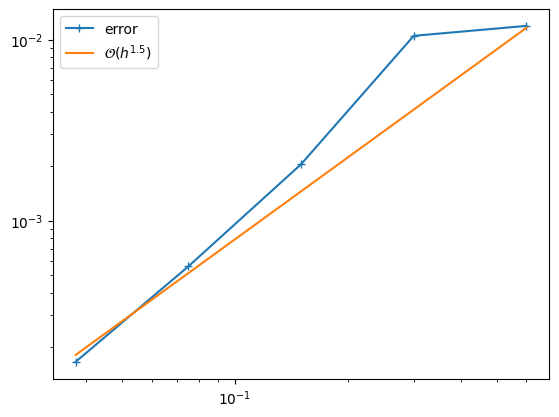

In [35]:
hnp = np.array(hm)
plt.loglog(hnp,l2_errors,label="error",marker= '+' ) 
plt.loglog(hnp,0.025*hnp**1.5,label="$\mathcal{O}(h^{1.5})$")
#plt.loglog(hnp,0.5*hnp**2,label="$\mathcal{O}(h^2)$")
plt.legend()
plt.show()

In [ ]:
hm = [ 1/5,1/10,1/20,1/40 ]
Ns = [1,2,4,8]
l2_errors = [0.005429633926597932,0.0009544099122872821,0.0002630333304316255,0.00015752188432953458 ]
eoc = [ log(l2_errors[i-1]/l2_errors[i])/log(2) for i in range(1,len(l2_errors))]

In [ ]:
print(eoc)

In [ ]:
1/32